In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os
from pathlib import Path

import matplotlib.pyplot as plt
import torch

from experiments.model_utils import load_medsam
from experiments.utils import (
    load_process_csv, process_slice, process_bbox_str, segment, split_seg, get_seg_bbox, \
    get_slices_filenames, segment_slice_sequence
)
from experiments.viz_utils import plot_results

device = 'cuda' if torch.cuda.is_available() else 'cpu'
medsam = load_medsam("../work_dir/MedSAM/medsam_vit_b.pth", device)

In [3]:
data_folder = Path("/home/liushifeng/Desktop/DeepLesion Dataset/")
df = load_process_csv(data_folder / "DL_info.csv")

batch_folders = [data_folder / f for f in os.listdir(data_folder) if f.startswith("Images_png_") and ".zip" not in f]

## Segment 2D slices

Scan name: 004428_01_01


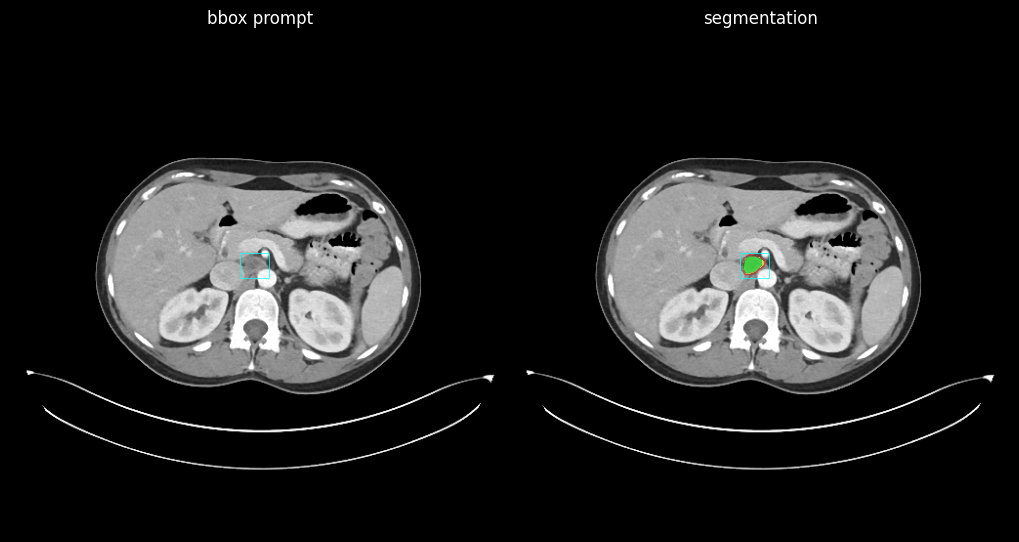

In [4]:
# %matplotlib inline
scan_folders = map(Path, glob.glob(str(data_folder / "Images_png_*/Images_png/*")))

# every scan_folder contains N png files
for scan_folder in scan_folders:
    scan_name = scan_folder.stem
    print("Scan name:", scan_name)
    df_scan = df[df['scan_name'].eq(scan_name)]

    for i in range(len(df_scan)):
        df_slice = df_scan.iloc[i]
        k = df_slice['Key_slice_index']

        key_slice_path = scan_folder / df_slice['file_name']
        lung, abdomen = process_slice(key_slice_path, rgb=True)

        bbox = [round(x) for x in process_bbox_str(df_slice['Bounding_boxes'])]
        seg = segment(abdomen, bbox, medsam)
        segs = split_seg(seg)

        plot_results(abdomen, [bbox], segs, plot=True,
                     save_path=f"outputs/{scan_name}_{k}")
        break
    break

## Extend to 3D

Observations
* works decent if the object is getting smaller (even without box adjustment), but eventually moves to another project
* doesn't work well if the object is getting bigger

In [7]:
df_slice = df_scan.iloc[0]

In [163]:
k = df_slice['Key_slice_index']
slice_filenames = get_slices_filenames(df_slice['Slice_range'].split(", "))
up_slice_paths = [scan_folder / f for f in slice_filenames if int(f.split(".")[0]) >= k]
down_slice_paths = [scan_folder / f for f in slice_filenames if int(f.split(".")[0]) <= k][::-1]


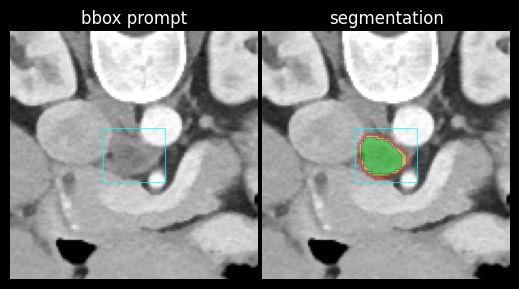

extend_3d/004428_01_01/start60_60


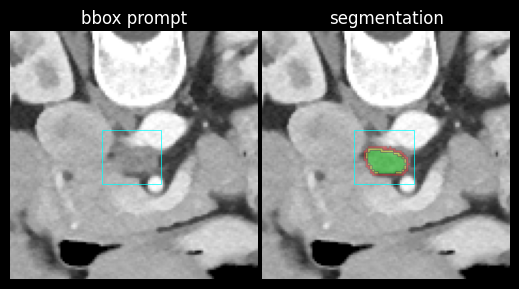

extend_3d/004428_01_01/start60_61


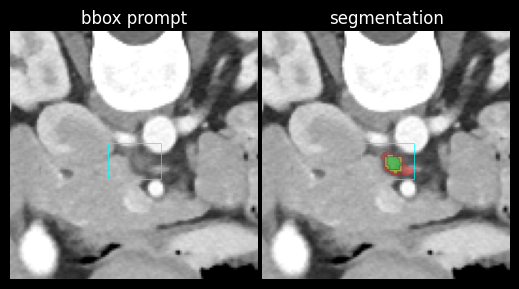

extend_3d/004428_01_01/start60_62


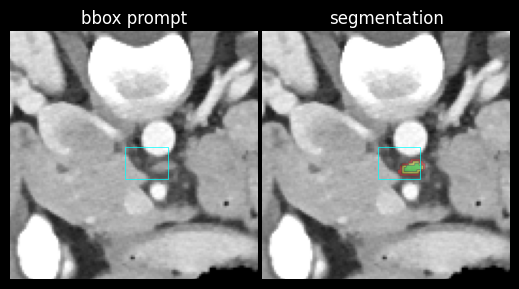

extend_3d/004428_01_01/start60_63


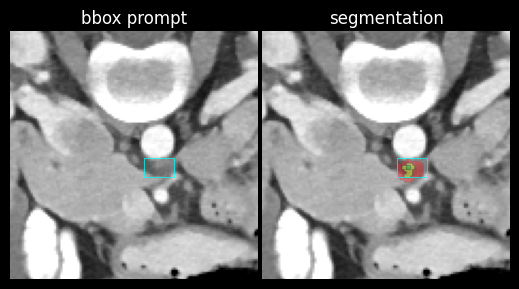

extend_3d/004428_01_01/start60_64


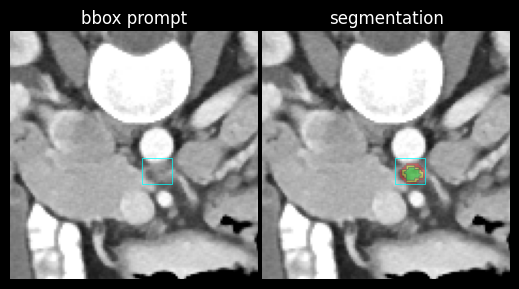

extend_3d/004428_01_01/start60_65


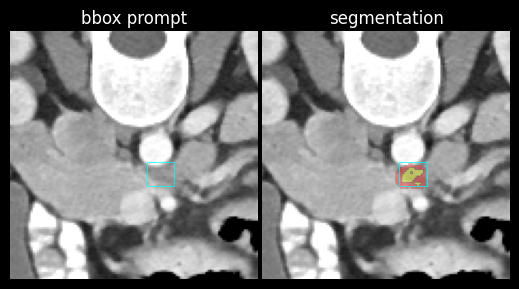

extend_3d/004428_01_01/start60_66


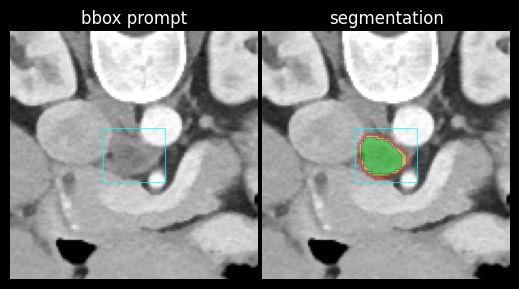

extend_3d/004428_01_01/start60_60


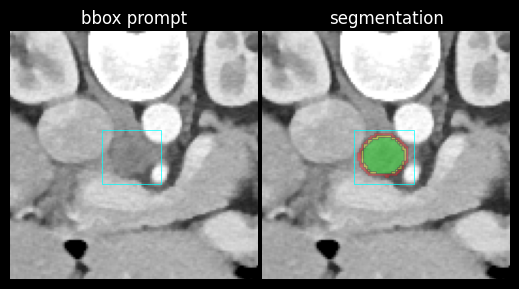

extend_3d/004428_01_01/start60_59


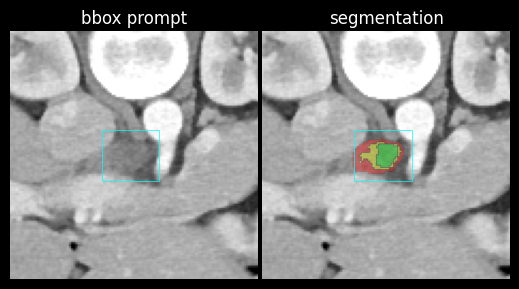

extend_3d/004428_01_01/start60_58


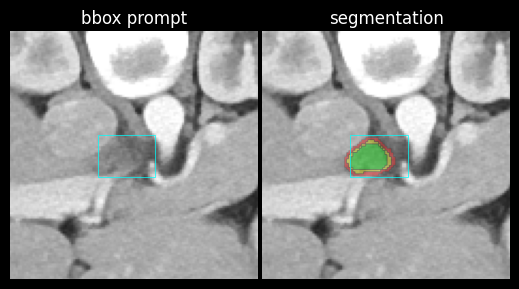

extend_3d/004428_01_01/start60_57


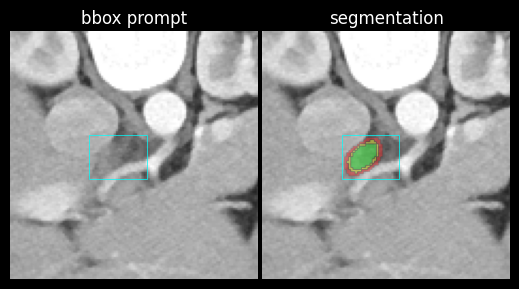

extend_3d/004428_01_01/start60_56


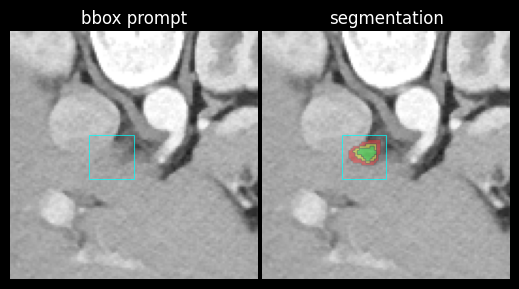

extend_3d/004428_01_01/start60_55


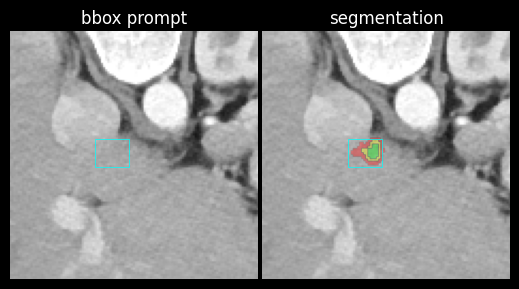

extend_3d/004428_01_01/start60_54


In [166]:
%matplotlib inline
up_slices, up_slice_segs = segment_slice_sequence(medsam, up_slice_paths, df_slice['bbox'], plot=True, save=True)
down_slices, down_slice_segs = segment_slice_sequence(medsam, down_slice_paths, df_slice['bbox'], plot=True, save=True)

In [67]:
import numpy as np
import pandas as pd

In [168]:
def get_slice_stats(slices, slice_segs):
    median_conf = []
    size = []
    intensity = []

    for i in range(len(slices)):
        img = np.array(slices[i])
        seg = slice_segs[i]
        low, mid, high = split_seg(seg)

        median_conf.append(np.median(seg[seg > 0.1]))
        size.append((mid.sum() + high.sum()))
        intensity.append(np.mean(img[high.astype(bool)]))

    # get stats of slices
    res = pd.DataFrame([median_conf, size, intensity]).T
    res.columns = ['median_conf', 'size', 'intensity']
    res = res / res.iloc[0]
    return res

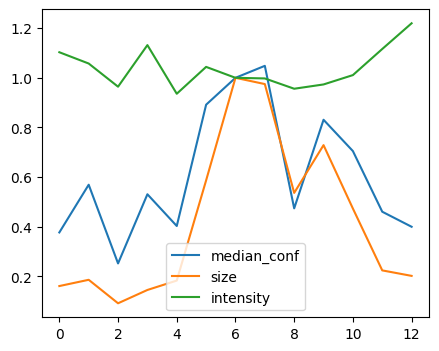

In [174]:
res_up = get_slice_stats(up_slices, up_slice_segs)
res_down = get_slice_stats(down_slices, down_slice_segs)

res = pd.concat([res_up.iloc[1:].iloc[::-1], res_down], axis=0).reset_index(drop=True)
res.plot(figsize=(5,4));

In [173]:
res_up.iloc[1:].iloc[::-1] +

,median_conf,size,intensity
6,0.376857,0.160883,1.103034
5,0.569192,0.186120,1.057558
4,0.252053,0.091483,0.964217
3,0.530736,0.145110,1.131744
2,0.402873,0.182965,0.935747
1,0.891624,0.586751,1.044012


In [ ]:
a

In [69]:
import numpy as np

# Calculate the centroid of the segs[2] 2D mask
mask = segs[2]
y, x = np.where(mask == 1)
centroid = (np.mean(x), np.mean(y)) if len(x) > 0 and len(y) > 0 else (None, None)
print("Centroid:", centroid)

Centroid: (247.42292490118578, 237.57707509881422)


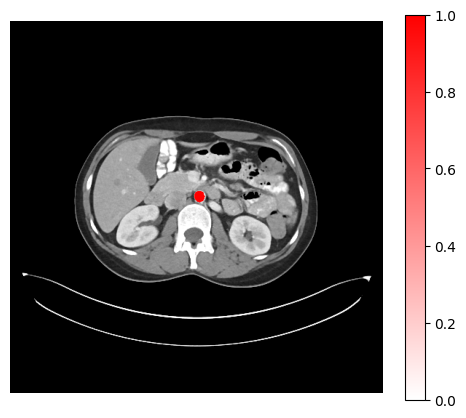

In [37]:
plt.figure(figsize=(6, 5));
plt.imshow(abdomen);
plt.imshow(segs[2], cmap=transparent_cmap("red"));
plt.colorbar();
plt.axis('off');